In [3]:
import sys
from pathlib import Path
import numpy as np
import cv2
import h5py
import pyrealsense2 as rs
import matplotlib.pyplot as plt

# load data

In [4]:
!ls ../ |grep ".hdf5"

Vhdf5_20181003_215318.hdf5
Vhdf5_20181020_000453.hdf5
Vhdf5_20181020_040132.hdf5
Vpyrealsense2_20181021_164627.bag.hdf5
pyrealsense2hdf5.py
read_from_file_Vhdf5.py
save_test_Vhdf5.py
touching.bag.hdf5
touching_no.bag.hdf5


In [5]:
def load_hdf5(filepath):
    h5f = h5py.File(filepath, 'r')
    color_frame= h5f['color']
    depth_frame= h5f['depth']
    IR_frame= h5f['IR']
    Total_frame = h5f['color'].shape[0]
    print("Total_frame: %d"%Total_frame)
    return color_frame, depth_frame, IR_frame

In [6]:
color_stream, depth_stream, IR_stream = load_hdf5("../Vpyrealsense2_20181021_164627.bag.hdf5")

Total_frame: 155


In [7]:
print(color_stream.shape)
print(depth_stream.shape)
print(IR_stream.shape)

(155, 480, 640, 3)
(155, 480, 640)
(155, 480, 640)


In [8]:
def show_frame(color_stream, IR_stream, depth_stream, i):
    color_image = color_stream[i][...,::-1]##bgt2rgb
    IR_image = IR_stream[i]
    depth_image = depth_stream[i]
    fig1 = plt.figure(figsize=(15,15))
    ax1 = fig1.add_subplot(131)
    ax2 = fig1.add_subplot(132)
    ax3 = fig1.add_subplot(133)
    ax1.imshow(color_image)
    ax2.imshow(IR_image, cmap='gray')
    ax3.imshow(depth_image)
    ax1.set_title('Color')
    ax2.set_title('IR')
    ax3.set_title('Depth')

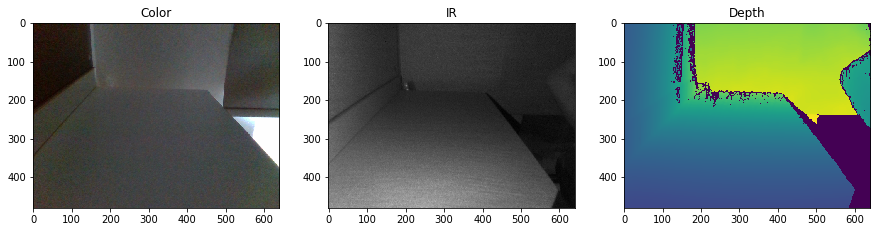

In [9]:
show_frame(color_stream, IR_stream, depth_stream, 30)

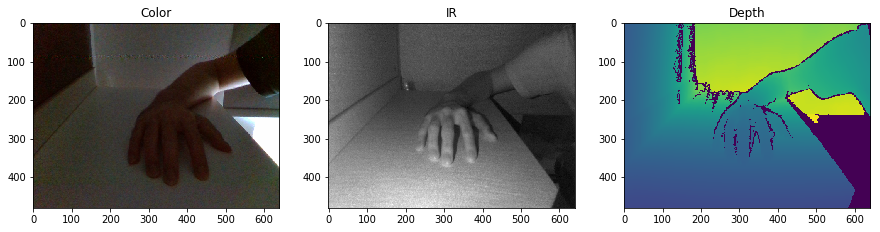

In [10]:
show_frame(color_stream, IR_stream, depth_stream, 50)

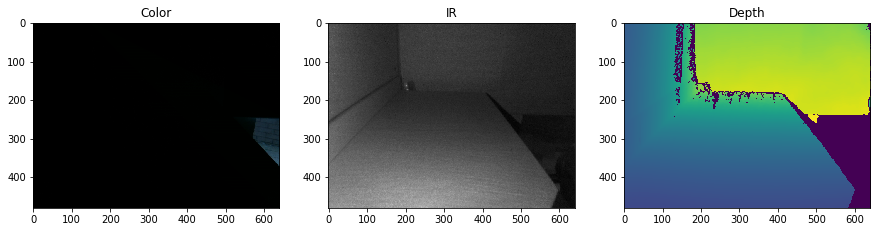

In [11]:
show_frame(color_stream, IR_stream, depth_stream, 0)

# feature extraction

In [12]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def depth2normalize(image,y_line_end = 0,show = True):
    if(y_line_end == 0):
        y_line_end = int(image.shape[0]/2.5)
    image_reverse = image[::-1]
    image_middle_x = int(image_reverse.shape[1]/2)
    x_train = np.array(range(y_line_end))
    y_train = image_reverse[:y_line_end, image_middle_x]
    image = np.full((y_line_end,100),y_train.reshape(-1, 1))
    ##
    popt, pcov = curve_fit(func, x_train, y_train)
    x_predict = np.array(range(image_reverse.shape[0]))
    y_predict = func(x_predict, *popt)
    if show:
        fig1 = plt.figure(figsize=(15,5))
        original = fig1.add_subplot(141)
        predict = fig1.add_subplot(142)
        o_and_p = fig1.add_subplot(143)
        matrix = fig1.add_subplot(144)
        
        original.plot(x_train, y_train)
        original.set_title('Real depth increment')
        
        predict.plot(x_predict[:len(x_train)], y_predict[:len(y_train)])
        predict.set_title('Predict depth increment')
        
        o_and_p.plot(x_train, y_train)
        o_and_p.plot(x_predict[:len(x_train)], y_predict[:len(y_train)])
        o_and_p.set_title('mix Real and Predict')
        
        matrix.imshow(cv2.applyColorMap(cv2.convertScaleAbs(image, alpha=0.03), cv2.COLORMAP_JET))
        matrix.set_title('estimate color of normaliz matrix')
        print(y_train)
    normalize_matrix = np.full(image_reverse.shape,y_predict.reshape(-1, 1))[::-1]
    return normalize_matrix

In [13]:
def subtract_normalization(depth_stream, normalize_matrix):
    ##the item is in the fount, so normalize_matrix-depth_stream
    ##we need int16, rather than float, normalize_matrix original float, change to uint16
    normalised = (normalize_matrix.astype(np.uint16) - depth_stream)
    ##==0 original no data, to 0, normalised>60000, depth_stream>normalize_matrix, error, to 0
    return np.abs(np.where((depth_stream==0)|(normalised>3000),0,normalised))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


[1456 1457 1458 1460 1463 1466 1470 1475 1480 1484 1489 1493 1497 1500
 1504 1508 1511 1515 1520 1524 1527 1532 1536 1540 1545 1550 1555 1559
 1563 1567 1571 1575 1579 1584 1588 1593 1598 1603 1607 1612 1616 1620
 1624 1630 1635 1640 1644 1649 1654 1658 1663 1667 1672 1677 1682 1686
 1691 1694 1699 1703 1708 1712 1717 1722 1727 1733 1739 1744 1750 1755
 1760 1765 1771 1777 1783 1789 1794 1799 1804 1810 1816 1822 1828 1834
 1839 1844 1849 1855 1860 1866 1872 1878 1883 1889 1895 1902 1908 1914
 1921 1928 1934 1940 1946 1952 1958 1964 1971 1978 1984 1989 1996 2002
 2009 2016 2024 2032 2038 2045 2052 2059 2066 2072 2079 2086 2093 2101
 2108 2116 2122 2129 2136 2143 2152 2160 2168 2176 2184 2191 2198 2206
 2214 2223 2232 2240 2249 2258 2266 2274 2282 2291 2300 2308 2315 2323
 2331 2340 2349 2358 2367 2376 2386 2397 2408 2417 2426 2434 2442 2451
 2461 2471 2482 2491 2502 2512 2521 2530 2538 2547 2558 2569 2580 2590
 2599 2610 2622 2634 2647 2658 2669 2679 2690 2701]


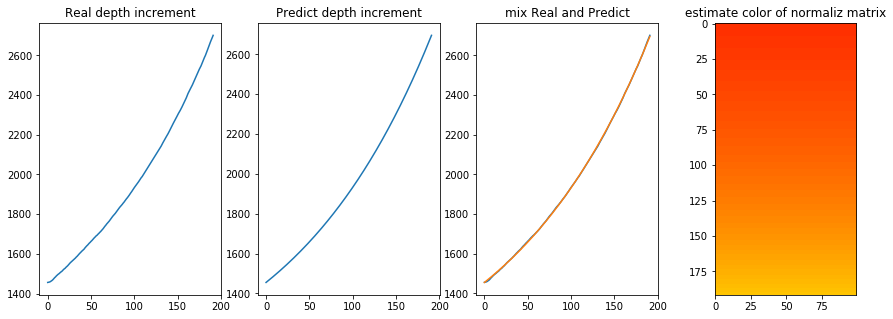

In [14]:
normalize_matrix = depth2normalize(depth_stream[30])

## success

In [15]:
MASKED = subtract_normalization(depth_stream[90], normalize_matrix)
MASKED.shape

(480, 640)

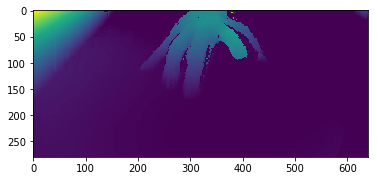

In [16]:
plt.imshow(MASKED[200:])

## wait...
a normal image subtract also work

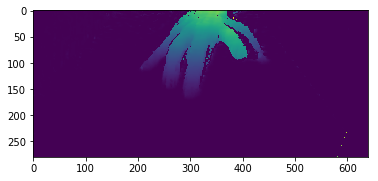

In [17]:
normalised = np.abs(depth_stream[30] - depth_stream[90])
normalised = np.abs(np.where((depth_stream[30]==0)|(normalised>2000),0,normalised))
plt.imshow(normalised[200:])

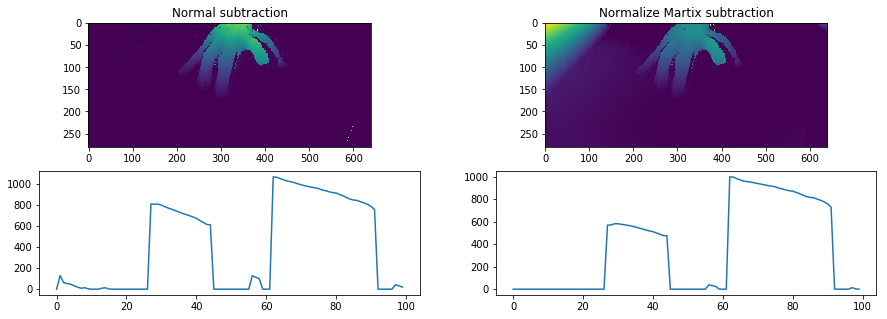

In [18]:
fig1 = plt.figure(figsize=(15,5))
image_n = fig1.add_subplot(221)
image_c = fig1.add_subplot(222)
fig_n = fig1.add_subplot(223)
fig_c = fig1.add_subplot(224)

image_n.imshow(normalised[200:])
image_c.imshow(MASKED[200:])
image_n.set_title('Normal subtraction')
image_c.set_title('Normalize Martix subtraction')
fig_n.plot(normalised[200:300,400])
fig_c.plot(MASKED[200:300,400])

# data test

## touching

In [19]:
!ls ../|grep ".bag.hdf5"

Vpyrealsense2_20181021_164627.bag.hdf5
touching.bag.hdf5
touching_no.bag.hdf5


In [20]:
t_color_stream, t_depth_stream, t_IR_stream = load_hdf5("../touching.bag.hdf5")

Total_frame: 233


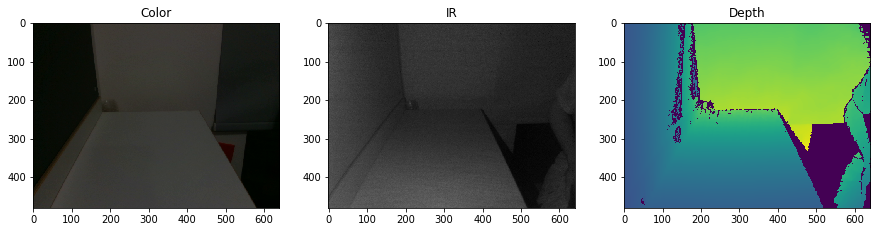

In [21]:
show_frame(t_color_stream,t_IR_stream, t_depth_stream,  232)

[2334 2334 2337 2342 2347 2353 2360 2368 2375 2382 2389 2395 2400 2406
 2412 2419 2426 2434 2441 2447 2453 2459 2466 2472 2479 2486 2493 2500
 2507 2514 2521 2528 2536 2543 2549 2555 2561 2568 2576 2583 2590 2596
 2604 2612 2620 2628 2635 2641 2648 2654 2662 2669 2676 2684 2692 2699
 2707 2715 2723 2730 2738 2745 2753 2761 2769 2776 2784 2792 2800 2809
 2818 2826 2835 2844 2853 2861 2868 2875 2881 2888 2896 2904 2912 2921
 2931 2940 2948 2956 2965 2974 2984 2994 3005 3016 3026 3036 3045 3054
 3063 3072 3081 3088 3098 3107 3117 3126 3135 3144 3154 3164 3174 3184
 3194 3205 3216 3226 3236 3247 3258 3270 3283 3296 3308 3320 3329 3338
 3348 3358 3371 3383 3396 3407 3419 3430 3440 3450 3461 3474 3487 3500
 3513 3524 3534 3543 3554 3566 3580 3593 3606 3618 3630 3640 3652 3664
 3678 3694 3708 3724 3738 3752 3767 3784 3800 3816 3830 3844 3859 3872
 3887 3901 3914 3928 3941 3957 3971 3985 4000 4016 4032 4049 4071 4089
 4106 4119 4134 4151 4168 4186 4202 4221 4238 4254 4273 4293 4315 4336
 4353 

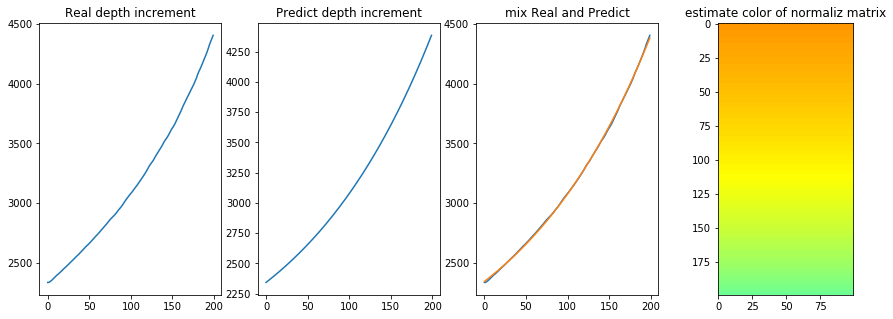

In [22]:
t_normalize_matrix = depth2normalize(t_depth_stream[232],200)

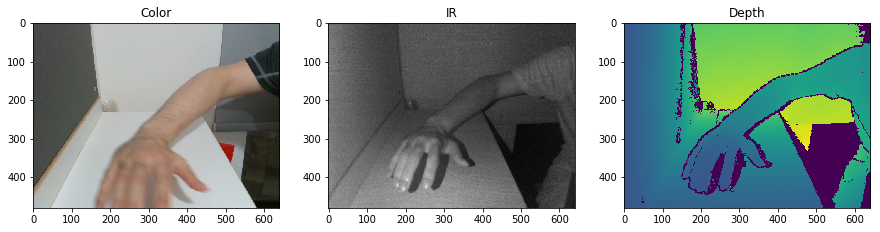

In [23]:
show_frame(t_color_stream, t_IR_stream, t_depth_stream, 140)

In [24]:
t_MASKED = subtract_normalization(t_depth_stream[140], t_normalize_matrix)
t_MASKED.shape

(480, 640)

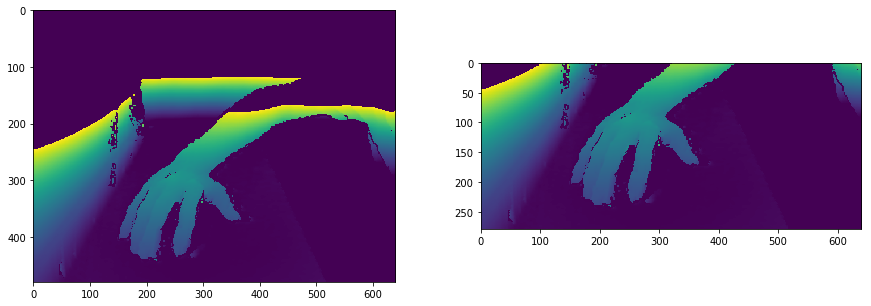

In [25]:
fig = plt.figure(figsize=(15,5))
original = fig.add_subplot(121)
cut = fig.add_subplot(122)
original.imshow(t_MASKED)
cut.imshow(t_MASKED[200:])

## not touching

In [26]:
!ls ../|grep ".bag.hdf5"

Vpyrealsense2_20181021_164627.bag.hdf5
touching.bag.hdf5
touching_no.bag.hdf5


In [27]:
nt_color_stream, nt_depth_stream, nt_IR_stream = load_hdf5("../touching_no.bag.hdf5")

Total_frame: 273


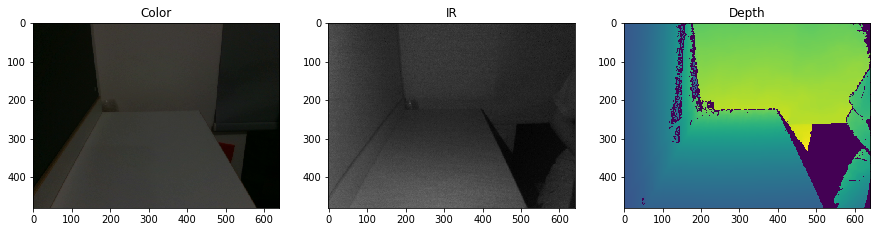

In [28]:
show_frame(nt_color_stream, nt_IR_stream, nt_depth_stream, 272)

[2340 2340 2343 2347 2352 2358 2365 2372 2378 2386 2392 2399 2405 2412
 2418 2425 2431 2438 2445 2452 2458 2465 2472 2478 2485 2492 2498 2505
 2511 2518 2524 2531 2538 2545 2553 2560 2568 2575 2583 2590 2596 2602
 2609 2617 2625 2634 2641 2648 2654 2659 2666 2673 2682 2690 2699 2708
 2714 2721 2728 2735 2741 2748 2754 2762 2770 2780 2790 2799 2807 2814
 2820 2828 2837 2846 2856 2864 2873 2880 2887 2895 2903 2911 2919 2928
 2938 2947 2957 2965 2974 2982 2992 3002 3012 3022 3032 3040 3048 3056
 3064 3073 3083 3094 3105 3114 3122 3131 3141 3152 3163 3174 3185 3194
 3202 3210 3219 3228 3240 3253 3267 3280 3294 3306 3316 3326 3335 3345
 3355 3366 3377 3390 3403 3416 3427 3438 3446 3456 3466 3478 3491 3505
 3518 3530 3541 3550 3561 3572 3584 3598 3613 3626 3638 3650 3662 3676
 3690 3705 3720 3737 3752 3765 3777 3789 3802 3817 3834 3852 3868 3882
 3896 3908 3922 3938 3956 3973 3990 4004 4018 4032 4048 4067 4084 4100
 4115 4130 4152 4176 4196 4209 4221 4235 4250 4266 4282 4298 4316 4333
 4353 

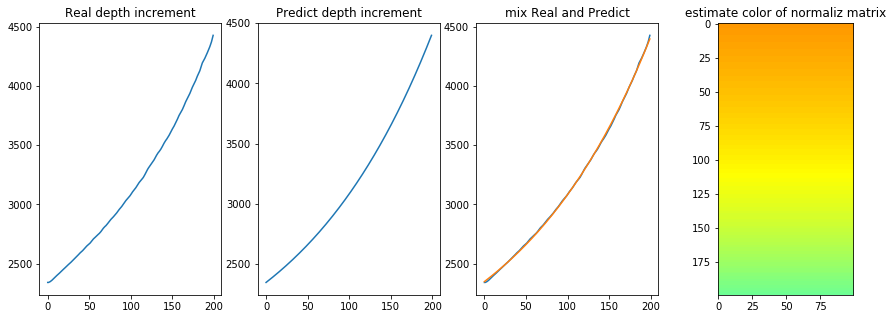

In [29]:
nt_normalize_matrix = depth2normalize(nt_depth_stream[272],200)

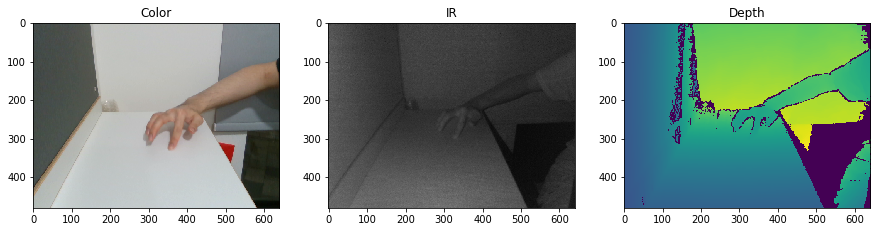

In [43]:
show_frame(nt_color_stream, nt_IR_stream, nt_depth_stream, 140)

In [31]:
nt_MASKED140 = subtract_normalization(nt_depth_stream[140], nt_normalize_matrix)

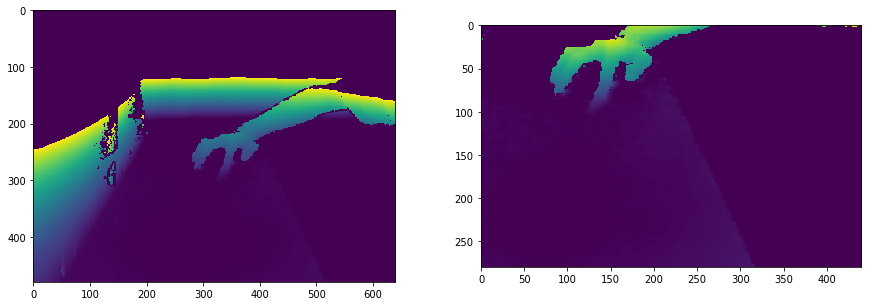

In [32]:
fig = plt.figure(figsize=(15,5))
original = fig.add_subplot(121)
cut = fig.add_subplot(122)
original.imshow(nt_MASKED140)
cut.imshow(nt_MASKED140[200:, 200:])
##because the scale of the color 

new image, easiler to show

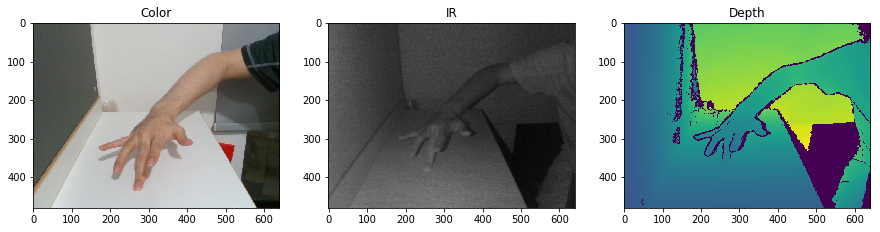

In [42]:
show_frame(nt_color_stream, nt_IR_stream , nt_depth_stream, 170)

In [34]:
nt_MASKED170 = subtract_normalization(nt_depth_stream[170], nt_normalize_matrix)
nt_MASKED170[:,265] = 1000
nt_MASKED170[:,280] = 1000

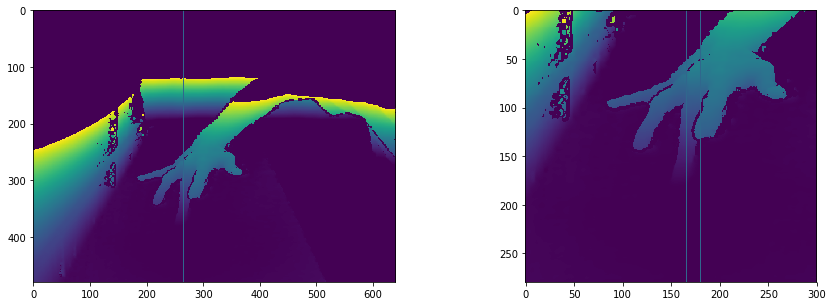

In [35]:
fig = plt.figure(figsize=(15,5))
original = fig.add_subplot(121)
cut = fig.add_subplot(122)
original.imshow(nt_MASKED170)
cut.imshow(nt_MASKED170[200:,100:400])
##because the scale of the color dominated by the higher number of back ground

## touching & not touching fecture

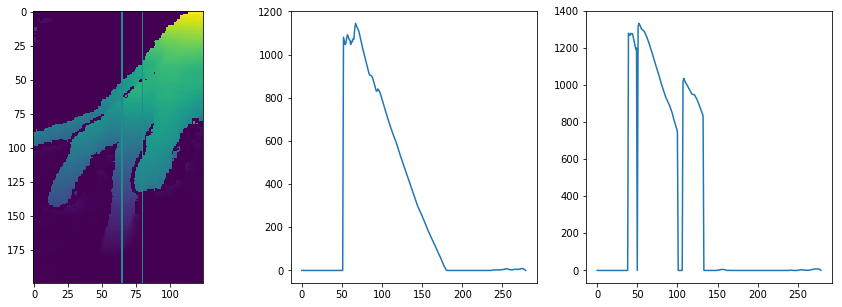

In [36]:
fig1 = plt.figure(figsize=(15,5))
location = fig1.add_subplot(131)
touch = fig1.add_subplot(132)
ntouch = fig1.add_subplot(133)
location.imshow(nt_MASKED170[200:400, 200:325])
nt_MASKED170 = subtract_normalization(nt_depth_stream[170], nt_normalize_matrix)#renew
touch.plot(nt_MASKED170[200:,265])
ntouch.plot(nt_MASKED170[200:,280])

# simple subtraction(I play myself) 
a normal image subtract also work

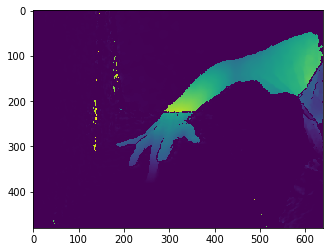

In [37]:
normalised = np.abs(nt_depth_stream[272] - nt_depth_stream[170])
normalised = np.abs(np.where((nt_depth_stream[272]==0)|(normalised>3000),0,normalised))
plt.imshow(normalised)

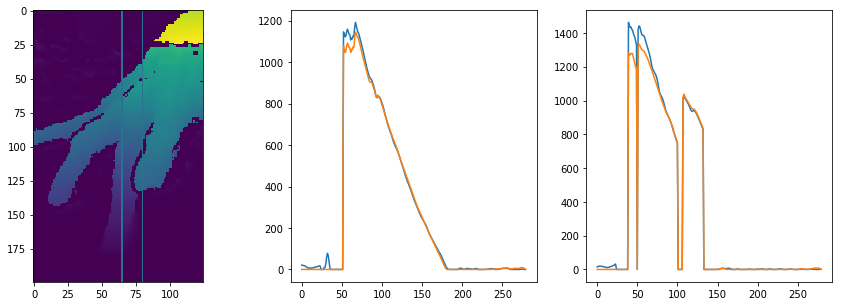

In [38]:
fig1 = plt.figure(figsize=(15,5))
location = fig1.add_subplot(131)
touch = fig1.add_subplot(132)
ntouch = fig1.add_subplot(133)
normalised_line = np.copy(normalised)
normalised_line[:,265] = 1000
normalised_line[:,280] = 1000
location.imshow(normalised_line[200:400, 200:325])
touch.plot(normalised[200:,265])
ntouch.plot(normalised[200:,280])
touch.plot(nt_MASKED170[200:,265])
ntouch.plot(nt_MASKED170[200:,280])

# difference

In [39]:
normalised = np.abs(nt_depth_stream[272] - nt_depth_stream[140])
normalised = np.abs(np.where((nt_depth_stream[272]==0)|(normalised>3000),0,normalised))
nt_MASKED140 = subtract_normalization(nt_depth_stream[140], nt_normalize_matrix)

fig1 = plt.figure(figsize=(15,15))
original = fig1.add_subplot(221)
cut = fig1.add_subplot(222)
original1 = fig1.add_subplot(223)
cut1 = fig1.add_subplot(224)

original.imshow(nt_MASKED140)
cut.imshow(nt_MASKED140[200:, 200:])
original1.imshow(normalised)
cut1.imshow(normalised[200:, 200:])

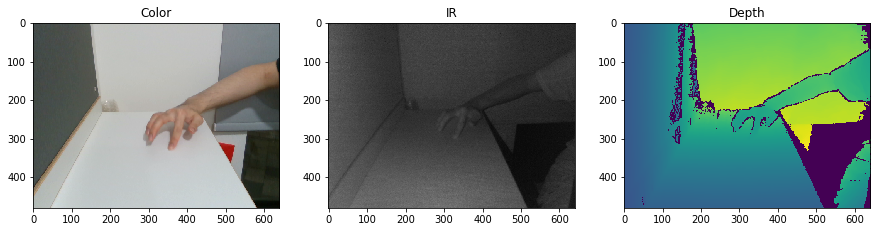

In [41]:
show_frame(nt_color_stream, nt_IR_stream, nt_depth_stream, 140)